In [211]:
# Importar bibliotecas
import json
import numpy as np
import pandas as pd

# WordCloud
import matplotlib.pyplot as plt
from PIL import Image
from wordcloud import WordCloud, STOPWORDS

# Importar o módulo de classificaçao de sentimentos
from sent_classifier import SnorkelSentimentClassifier

pd.set_option('display.max_colwidth', None)

### 1. Suno Research

In [212]:
ticker: str = 'VALE3'
start_dt: str = '2018-01-02'
end_dt: str = '2022-07-02' 

In [213]:
def load_suno_files(ticker: str, start_dt: str, end_dt: str) -> pd.DataFrame:
    """
    Loads JSON files from Suno Research data.
    """

    df_news = pd.read_csv('../crawlers/suno/final/df_suno_with_mentions.csv', sep=';')

    # Convert date to datetime format
    df_news['date'] = pd.to_datetime(df_news['date'], format='%Y-%m-%d %H:%M:%S')

    # Remove duplicates
    df_news = df_news.drop_duplicates(subset=['date', 'title'], keep ='first')

    # Set date column as index
    df_news.set_index('date', inplace=True)

    # Order by date
    df_news.sort_index(inplace=True)

    # Add ticker Info
    df_news = df_news[df_news['ticker'] == ticker.upper()]

    # Filter Dates
    df_news = df_news.loc[start_dt:end_dt]

    return df_news

In [214]:
df = load_suno_files(ticker=ticker, start_dt=start_dt, end_dt=end_dt)
df.sample(5)

,topic,title,search_date,url,tags,ticker
date,,,,,,
2019-10-25 19:41:00,Mercado,"Ibovespa sobe 0,35% com alta das ações da Petrobras",2022-05-03 16:44:52,https://www.suno.com.br/noticias/ibovespa-sobe-035-com-alta-das-acoes-da-petrobras/,"['AMBEV (ABEV3)', 'Ibovespa', 'Petrobras (PETR4)', 'Santander (SANB11/SANB3/SANB4)', 'Vale (VALE3)']",VALE3
2021-09-17 11:22:00,Mercado,Ibovespa abre em queda com minério de ferro e IOF no radar; Vale (VALE3) cai 3%,2022-05-03 16:32:09,https://www.suno.com.br/noticias/ibovespa-abre-queda-minerio-alta-iof-vale-vale3/,"['Bolsas mundiais', 'Especialistas', 'Gol Linhas Aéreas (GOLL11/GOLL4)', 'Ibovespa', 'Lojas Renner (LREN3)', 'minério de ferro', 'Vale (VALE3)']",VALE3
2021-10-28 21:50:00,Negócios,"Vale (VALE3) lucra US$ 3,88 bi no 3T21, alta de 34%, abaixo das estimativas",2022-08-04 00:15:58,https://www.suno.com.br/noticias/vale-vale3-lucro-3t21/,"['balanços trimestrais', 'balanços trimestrais', 'Vale (VALE3)']",VALE3
2020-07-28 15:48:00,Negócios,Vale (VALE3) constrói primeira locomotiva 100% elétrica do setor no Brasil,2022-05-03 16:42:10,https://www.suno.com.br/noticias/vale-vale3-primeira-locomotiva-eletrica-setor-brasil/,"['ESG', 'Vale (VALE3)']",VALE3
2019-03-20 20:44:00,Mercado,Minério de ferro cai 6% na China após Justiça autorizar Vale a retomar mina,2022-05-03 16:47:05,https://www.suno.com.br/noticias/minerio-ferro-justica-vale-retomar/,"['Brumadinho', 'China', 'minério de ferro', 'Vale (VALE3)']",VALE3


In [215]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 854 entries, 2018-08-28 11:34:00 to 2022-07-01 13:18:00
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   topic        854 non-null    object
 1   title        854 non-null    object
 2   search_date  854 non-null    object
 3   url          854 non-null    object
 4   tags         854 non-null    object
 5   ticker       854 non-null    object
dtypes: object(6)
memory usage: 46.7+ KB


In [216]:
sc = SnorkelSentimentClassifier(df=df, source='suno')

In [217]:
# Executar o módulo de classificação de sentimentos
df_results, results = sc.apply_rules(df)

100%|██████████| 5000/5000 [00:02<00:00, 1787.93epoch/s]


In [218]:
# Set values to label classes
scores = {"POSITIVE" : 1,
          "NEUTRAL" : 0,
          "NEGATIVE" : -1}

df_results["label_value"] = df_results["label_class"].map(scores)

In [219]:
# Compute scores per publication
df_results['sent_score'] = df_results['label_value'] * 1

In [220]:
scores = pd.DataFrame(df_results.sent_score)
daily_publications = scores.resample('D').nunique()

for index, row in df_results.iterrows():

    # Get sum of daily scores
    index_dt = index.date()
    count_dt = daily_publications.loc[str(index_dt)].values[0]

    # Set new value for sent_score
    df_results.loc[index, 'sent_score'] = row['sent_score'] / count_dt

In [221]:
df_results.tail(10)

,title,title_raw,search_date,label_class,label_value,sent_score
date,,,,,,
2022-05-27 15:38:00,com impulso da vale vale3 e ambev abev3 dividendos de empresas brasileiras saltam <NUM> por cento no 1t22,"Com impulso da Vale (VALE3) e Ambev (ABEV3), dividendos de empresas brasileiras saltam 7,4% no 1T22",2022-08-04 00:14:38,NEUTRAL,0.0,0.0
2022-05-28 10:01:00,warren buffett gasta <NUM> bi em ações vale vale3 entre as maiores pagadoras de dividendos do mundo veja as notícias mais lidas da semana,"Warren Buffett gasta US$ 51 bi em ações, Vale (VALE3) entre as maiores pagadoras de dividendos do mundo: veja as notícias mais lidas da semana",2022-08-04 00:14:35,POSITIVE,1.0,1.0
2022-05-31 15:16:00,vale vale3 deposita <NUM> bilhão por acordo de reparação de brumadinho,"Vale (VALE3) deposita R$ 1,2 bilhão por Acordo de Reparação de Brumadinho",2022-08-04 00:14:32,NEUTRAL,0.0,0.0
2022-06-01 12:57:00,em <NUM> vale vale3 pagou <NUM> bi em impostos e royalties no mundo alta de <NUM> por cento,"Em 2021, Vale (VALE3) pagou US$ 9,3 bi em impostos e royalties no mundo, alta de 63%",2022-08-04 00:13:47,NEUTRAL,0.0,0.0
2022-06-06 12:06:00,ibovespa em queda ações da vale vale3 sobem com avanço do minério de ferro,Ibovespa em queda; ações da Vale (VALE3) sobem com avanço do minério de ferro,2022-08-04 00:15:02,NEGATIVE,-1.0,-1.0
2022-06-08 13:11:00,ativa troca americanas amer3 por magazine luiza mglu3 veja as recomendações,Ativa troca Americanas (AMER3) por Magazine Luiza (MGLU3); veja as recomendações,2022-08-04 00:14:45,NEUTRAL,0.0,0.0
2022-06-09 18:28:00,ibovespa segue exterior e perde <NUM> por cento na 5ª queda consecutiva vale vale3 e csn csna3 caem,"Ibovespa segue exterior e perde 1,18%, na 5ª queda consecutiva; Vale (VALE3) e CSN (CSNA3) caem",2022-08-04 00:14:55,NEUTRAL,0.0,0.0
2022-06-09 19:19:00,vale vale3 lança fundo para investir <NUM> milhões em startups,Vale (VALE3) lança fundo para investir R$ 490 milhões em startups,2022-08-04 00:14:58,POSITIVE,1.0,0.5
2022-06-20 22:57:00,csn csna3 estuda oferta pela samarco vale vale3 e bhp dizem que empresa não está à venda,CSN (CSNA3) estuda oferta pela Samarco; Vale (VALE3) e BHP dizem que empresa “não está à venda”,2022-08-04 00:15:04,NEUTRAL,0.0,0.0


In [222]:
converter = lambda x : -1 if x < 0 else (1 if x > 0 else 0)
daily_sent_scores = pd.DataFrame(df_results.sent_score.resample('D').sum().apply(converter))

# Normalization
# Mean Normalization
# daily_sent_scores = (daily_sent_scores - daily_sent_scores.mean()) / daily_sent_scores.std()

# Min-Max Normalization
# daily_sent_scores = (daily_sent_scores-daily_sent_scores.min()) / (daily_sent_scores.max()-daily_sent_scores.min())

# Shift One Day (Get Previous Day Sents)
# daily_sent_scores = daily_sent_scores.shift().dropna()

daily_sent_scores.to_csv(f'../../data/textual/news/suno_daily_sent_scores_{ticker.upper()}.csv')
daily_sent_scores

,sent_score
date,
2018-08-28,0
2018-08-29,0
2018-08-30,0
2018-08-31,0
2018-09-01,0
...,...
2022-06-27,0
2022-06-28,0
2022-06-29,0


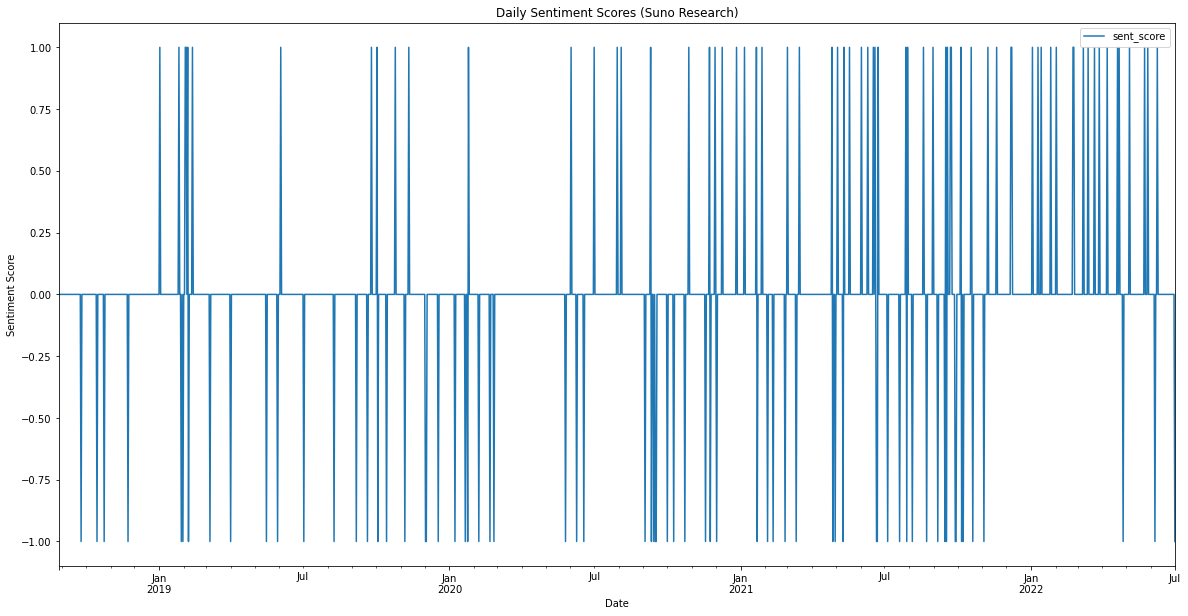

In [223]:
fig, ax = plt.subplots(figsize=(20,10))
daily_sent_scores.plot(ax=ax)
ax.set_title('Daily Sentiment Scores (Suno Research)')
ax.set_xlabel('Date')
ax.set_ylabel('Sentiment Score')
plt.show();

In [224]:
df_results.label_class.value_counts()

NEUTRAL     669
POSITIVE     87
NEGATIVE     86
Name: label_class, dtype: int64

In [225]:
results

,j,Polarity,Coverage,Overlaps,Conflicts
lf_news_good_adjs,0,[1],0.063232,0.011710,0.005855
lf_news_good_verbs,1,[1],0.026932,0.010539,0.000000
lf_regex_dividendos,2,[1],0.031616,0.010539,0.000000
lf_regex_resultado_positivo,3,[1],0.030445,0.003513,0.003513
lf_news_bad_adjs,4,[0],0.018735,0.003513,0.002342
lf_news_bad_verbs,5,[0],0.014052,0.001171,0.001171
lf_regex_resultado_negativo,6,[0],0.057377,0.008197,0.007026


---

### WordClouds

In [226]:
def generate_wordcloud(samples, sentiment, source):

    # Use a image as mask if source is twitter
    twitter_mask = np.array(Image.open("./wordclouds/twitter_mask.png"))

    # concatenar as palavras
    all_words = " ".join(s for s in samples)

    # ver quantidade de palavras
    print("Quantidade de Palavras: {}".format(len(all_words)))

    # lista de stopword
    stopwords = set(STOPWORDS)

    stopwords.update(["de", "e", "a", "um", "que", "com",
                    "só", "da", "do", "m", "a", "ou", "já",
                    "ok", "esse", "ma", "i", "mais", "mas",
                    "não", "meu", "pra", "eu", "uma", "um", 
                    "na", "no", "me", "tem", "em", "por",
                    "ele", "essa", "esse", "se", "vc", "para",
                    "vai", "muito", "minha", "meu", "ele", "ela",
                    "como", "sem", "tá", "dia", "você", "queria",
                    "aqui", "era", "as", "pq", "hoje", "seu", "gente", 
                    "nem", "como", "agora", "os", "quando", "foi", 
                    "isso", "casa", "ser", "ter", "cara", "vou", "NUM"])

    # gerar uma wordcloud
    wordcloud = WordCloud(stopwords=stopwords,
                        background_color="white",
                        max_words=1000,
                        mask=twitter_mask if source == 'twitter' else None,
                        width=1600, 
                        height=800,
                        contour_width=2,
                        collocations=False,
                        contour_color='#1da1f2').generate(all_words)

    # mostrar a imagem final
    fig, ax = plt.subplots(figsize=(15,10))
    ax.imshow(wordcloud, interpolation='bilinear')
    ax.set_axis_off()

    plt.imshow(wordcloud);
    
    # salvar a imagem final
    wordcloud.to_file(f"wordclouds/{source}_{sentiment}_wordcloud.png")

    plt.show();

#### Positive Suno

In [227]:
positive_samples = df_results[df_results['label_class'] == 'POSITIVE']['title'].tolist()

Quantidade de Palavras: 7095


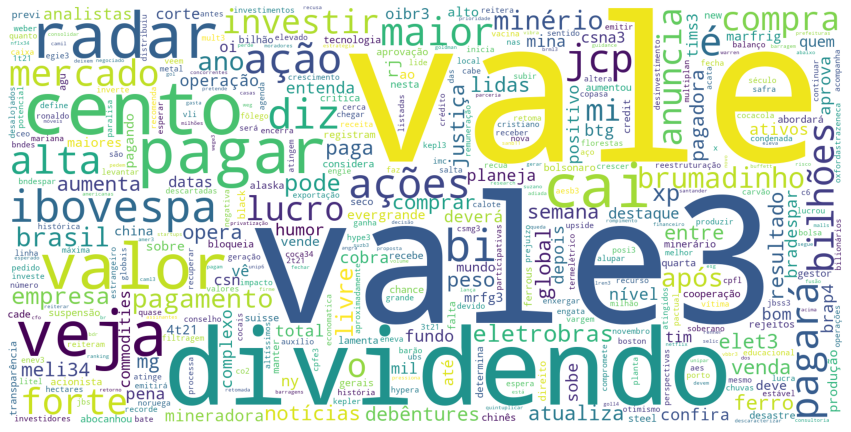

In [228]:
try:
    generate_wordcloud(positive_samples, 'positive', 'suno')
except ValueError:
    print (f'Sem palavras disponíveis para plotar a wordcloud.')

#### Negative Suno

In [229]:
negative_samples = df_results[df_results['label_class'] == 'NEGATIVE']['title'].tolist()

Quantidade de Palavras: 6269


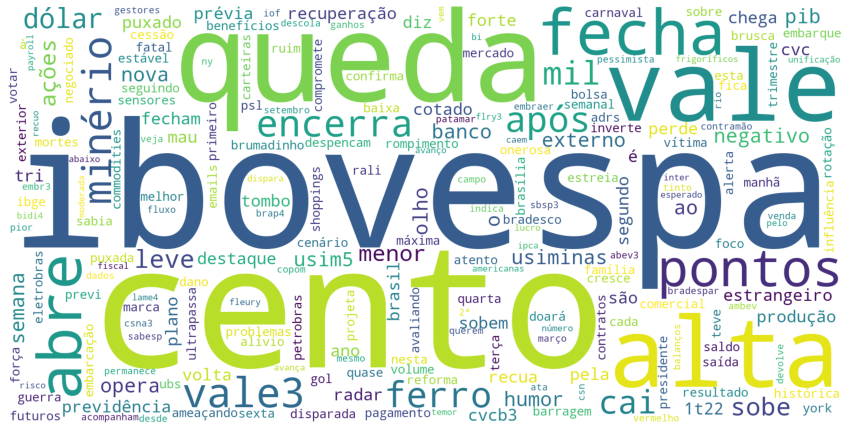

In [230]:
try:
    generate_wordcloud(negative_samples, 'negative', 'suno')
except ValueError:
    print (f'Sem palavras disponíveis para plotar a wordcloud.')

---

## Twitter

In [231]:
def load_twitter_files(ticker: str, start_dt: str, end_dt: str) -> pd.DataFrame:
    """
    Loads JSON files from Suno Research data.
    """

    df_related = pd.read_csv('../crawlers/twitter/final/df_twitter_related_users_with_mentions.csv', sep=';')
    df_specific = pd.read_csv('../crawlers/twitter/final/df_twitter_specific_users_with_mentions.csv', sep=';')

    df_twitter = pd.concat([df_specific, df_related])

    df_twitter.rename(columns={'text': 'title'}, inplace=True)

    # Convert date to datetime format
    df_twitter['date'] = pd.to_datetime(df_twitter['created_at'], format='%Y-%m-%d %H:%M:%S')

    # Remove duplicates
    df_twitter = df_twitter.drop_duplicates(subset=['date', 'title', 'screen_name'], keep ='first')

    # Set date column as index
    df_twitter.set_index('date', inplace=True)

    # Order by date
    df_twitter.sort_index(inplace=True)

    # Add ticker Info
    df_twitter = df_twitter[df_twitter['ticker'] == ticker.upper()]

    # Filter Dates
    df_twitter = df_twitter.loc[start_dt:end_dt]

    if df_twitter.empty:
        return pd.DataFrame()

    return df_twitter

In [232]:
df = load_twitter_files(ticker=ticker, start_dt=start_dt, end_dt=end_dt)
df.sample(5)

,Unnamed: 0,tweet_id,created_at,search_dt,title,user_id,screen_name,rt_count,favorite_count,ticker
date,,,,,,,,,,
2021-04-14 07:50:42,389,1382285177888632835,2021-04-14 07:50:42,2022-08-02 00:50:35,VACINA A DOMICÍLIO. Beep quer ser ‘a clínica de tudo’ — e já vale R$ 670 milhões https://t.co/nC7y0aHH4l https://t.co/5RFrhtYm3i,2424278232,BrazilJournal,3.0,38.0,VALE3
2022-03-04 20:01:00,130,1499882631512698888,2022-03-04 20:01:00,2022-08-02 00:49:37,Suno analisa Banco Inter (BIDI11); Veja se vale a pena investir https://t.co/yc4wGBOMTW https://t.co/krgmaaBzEP,25503983,acionistacombr,0.0,0.0,VALE3
2020-09-28 11:02:11,344,1310580566857781251,2020-09-28 11:02:11,2022-08-02 00:50:36,"EXCLUSIVO: VTEX já vale US$ 1,7 bilhão e é o novo unicórnio brasileiro https://t.co/iCxI1l2gpR https://t.co/1xpUpcq16s",2424278232,BrazilJournal,8.0,68.0,VALE3
2021-12-21 11:01:40,1722,1473292589227024397,2021-12-21 11:01:40,2022-08-02 00:57:01,Vale anuncia a venda de seus ativos de carvão #vale https://t.co/wuQu8ljHUt,1124834863520022529,Fatosdomercado,0.0,5.0,VALE3
2021-09-30 09:42:56,1562,1443556970892496897,2021-09-30 09:42:56,2022-08-02 00:57:06,VALE - Regularização da circulação de trens no Complexo de Mariana https://t.co/dC93NRarbF,1124834863520022529,Fatosdomercado,0.0,0.0,VALE3


In [233]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 498 entries, 2018-01-15 10:17:03 to 2022-07-02 08:48:07
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Unnamed: 0      498 non-null    int64  
 1   tweet_id        498 non-null    int64  
 2   created_at      498 non-null    object 
 3   search_dt       498 non-null    object 
 4   title           498 non-null    object 
 5   user_id         498 non-null    int64  
 6   screen_name     498 non-null    object 
 7   rt_count        498 non-null    float64
 8   favorite_count  498 non-null    float64
 9   ticker          498 non-null    object 
dtypes: float64(2), int64(3), object(5)
memory usage: 42.8+ KB


In [234]:
sc = SnorkelSentimentClassifier(df=df, source='twitter')

In [235]:
# Executar o módulo de classificação de sentimentos
df_results, results = sc.apply_rules(df)

100%|██████████| 5000/5000 [00:02<00:00, 1784.12epoch/s]


In [236]:
df_results.tail(10)

,title,title_raw,created_at,search_dt,rt_count,favorite_count,label_class
date,,,,,,,
2022-06-30 09:50:13,hoje é o último dia para inscrever o seu projeto cultural na chama instituto cultural vale é a chance de ter o seu projeto cultural patrocinado por nós hein corre para se inscrever,"Hoje é o último dia para inscrever o seu projeto cultural na Chama Instituto Cultural Vale. É a chance de ter o seu projeto cultural patrocinado por nós, hein. Corre para se inscrever https://t.co/wzlZEzcRKb https://t.co/LFIEsR19NS",2022-06-30 09:50:13,2022-08-02 00:52:45,2.0,5.0,NEUTRAL
2022-06-30 10:21:54,rápidas vale traders club fleury suzano valid yduqs unifique maxion ambipar finance news,"Rápidas: Vale, Traders Club, Fleury, Suzano, Valid, Yduqs, Unifique, Maxion, Ambipar - Finance News \nhttps://t.co/jOVBBeOdkk\n#ações",2022-06-30 10:21:54,2022-08-02 00:48:57,0.0,1.0,NEUTRAL
2022-06-30 14:54:28,vale deve ter volume fraco no <NUM> tri enquanto da gerdau sobe cba pode ter capital de giro negativo diz citi,"Vale deve ter volume fraco no 2º tri enquanto da Gerdau sobe; CBA pode ter capital de giro negativo, diz Citi\nhttps://t.co/bjXwO8iuO1",2022-06-30 14:54:28,2022-08-02 00:58:37,1.0,4.0,NEGATIVE
2022-06-30 16:02:37,vale vale3 avança na adoção de combustíveis de baixo carbono para navios mineraleiros,Vale (VALE3) avança na adoção de combustíveis de baixo carbono para navios mineraleiros https://t.co/7rV8yyMq2k,2022-06-30 16:02:37,2022-08-02 00:51:11,0.0,15.0,NEUTRAL
2022-06-30 16:42:26,ecorodovias ecor3 cai mais de <NUM> por cento no ano vale a pena investir na ação,Ecorodovias (ECOR3) cai mais de 20% no ano. Vale a pena investir na ação? - https://t.co/BgvG4ncHec,2022-06-30 16:42:26,2022-08-02 00:59:05,0.0,4.0,POSITIVE
2022-07-01 11:11:54,eneva firma contrato de fornecimento de gnl para a vale finance news,Eneva firma contrato de fornecimento de GNL para a Vale - Finance News \nhttps://t.co/jfeUbc0vwN\n#Eneva #ENEV3,2022-07-01 11:11:54,2022-08-02 00:48:57,0.0,2.0,NEUTRAL
2022-07-01 11:41:41,research camil é compra com estratégia de mampas e vale <NUM> diz itaú bba,"RESEARCH. Camil é ‘compra’ com estratégia de M&amp;As e vale R$ 13, diz Itaú BBA https://t.co/nsLuYJErrP #CAML3 https://t.co/bw1nBgZqPL",2022-07-01 11:41:41,2022-08-02 00:50:29,1.0,18.0,NEUTRAL
2022-07-01 12:22:12,vale e eneva assinam contrato para fornecimento de gás através de nota ao mercado a vale vale3 anunciou que fechou um contrato de gás natural para sua usina de pelotização,Vale e Eneva assinam contrato para fornecimento de gás. Através de nota ao mercado a Vale (VALE3) anunciou que fechou um contrato de gás natural para sua usina de pelotização \nhttps://t.co/y0PwjVDxI2\n#vale #eneva #gas #pelotização #investimento #sustentabilidade https://t.co/KkmhvWtnCH,2022-07-01 12:22:12,2022-08-02 00:57:49,0.0,0.0,NEUTRAL
2022-07-01 13:35:34,acerta com eneva contrato de gás natural para usina de pelotização no maranhão vale,#Vale acerta com Eneva contrato de gás natural para usina de pelotização no Maranhão - https://t.co/VJIkuqgqr6 \n\n#VALE3 $VALE,2022-07-01 13:35:34,2022-08-02 00:59:04,2.0,11.0,NEUTRAL


In [237]:
df_results.label_class.value_counts()

NEUTRAL     328
POSITIVE     92
NEGATIVE     73
Name: label_class, dtype: int64

In [238]:
results

,j,Polarity,Coverage,Overlaps,Conflicts
lf_news_good_adjs,0,[1],0.116466,0.024096,0.018072
lf_news_good_verbs,1,[1],0.190763,0.008032,0.000000
lf_regex_dividendos,2,[1],0.012048,0.002008,0.000000
lf_regex_resultado_positivo,3,[],0.000000,0.000000,0.000000
lf_news_bad_adjs,4,[0],0.036145,0.016064,0.014056
lf_news_bad_verbs,5,[],0.000000,0.000000,0.000000
lf_regex_resultado_negativo,6,[0],0.016064,0.008032,0.006024


### WordClouds

#### Positive Twitter

In [239]:
positive_samples = df_results[df_results['label_class'] == 'POSITIVE']['title'].tolist()

Quantidade de Palavras: 7747


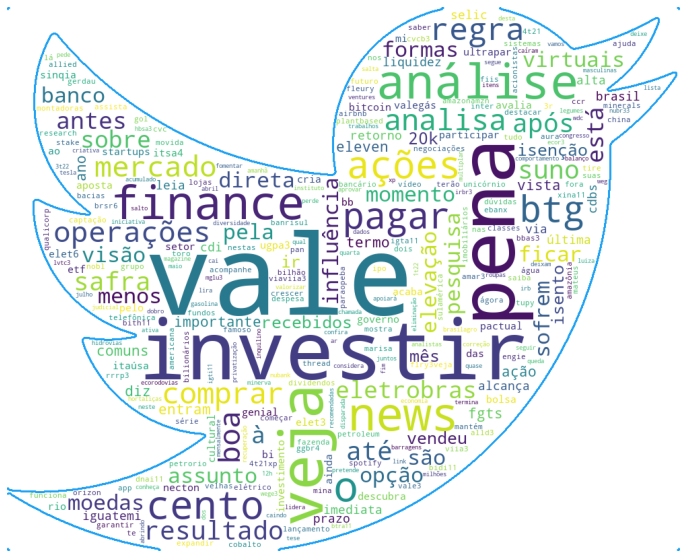

In [240]:
try:
    generate_wordcloud(positive_samples, 'positive', 'twitter')
except ValueError:
    print (f'Sem palavras disponíveis para plotar a wordcloud.')

#### Negative Twitter

In [241]:
negative_samples = df_results[df_results['label_class'] == 'NEGATIVE']['title'].tolist()

Quantidade de Palavras: 9674


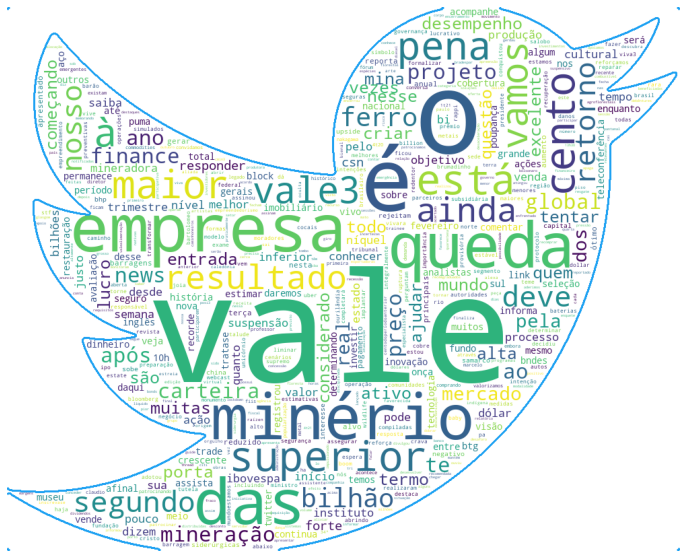

In [242]:
try:
    generate_wordcloud(negative_samples, 'negative', 'twitter')
except ValueError:
    print (f'Sem palavras disponíveis para plotar a wordcloud.')

---

### Aggregate Sentiment Scores

#### Using RTs e Favorite Count

In [243]:
df_results.head(2)

,title,title_raw,created_at,search_dt,rt_count,favorite_count,label_class
date,,,,,,,
2018-01-15 10:17:03,bhp pede à vale <NUM> bi pela participação na samarco fontes,BHP pede à Vale US$ 1 bi pela participação na Samarco: Fontes https://t.co/ZYN4pwcgL2 https://t.co/jqNrYEMAl0,2018-01-15 10:17:03,2022-08-02 00:46:07,1.0,1.0,NEUTRAL
2018-03-28 17:20:05,mesmo em nova fase vale mantém salário de executivos em segredo,"Mesmo em nova fase, Vale mantém salário de executivos em segredo: https://t.co/HFU1YmsJPh https://t.co/UyVCJSnkpx",2018-03-28 17:20:05,2022-08-02 00:46:07,0.0,2.0,NEUTRAL


In [244]:
# Set values to label classes
scores = {"POSITIVE" : 1,
          "NEUTRAL" : 0,
          "NEGATIVE" : -1}

df_results["label_value"] = df_results["label_class"].map(scores)

In [245]:
df_results.head(2)

,title,title_raw,created_at,search_dt,rt_count,favorite_count,label_class,label_value
date,,,,,,,,
2018-01-15 10:17:03,bhp pede à vale <NUM> bi pela participação na samarco fontes,BHP pede à Vale US$ 1 bi pela participação na Samarco: Fontes https://t.co/ZYN4pwcgL2 https://t.co/jqNrYEMAl0,2018-01-15 10:17:03,2022-08-02 00:46:07,1.0,1.0,NEUTRAL,0.0
2018-03-28 17:20:05,mesmo em nova fase vale mantém salário de executivos em segredo,"Mesmo em nova fase, Vale mantém salário de executivos em segredo: https://t.co/HFU1YmsJPh https://t.co/UyVCJSnkpx",2018-03-28 17:20:05,2022-08-02 00:46:07,0.0,2.0,NEUTRAL,0.0


In [246]:
# Compute scores per publication
df_results['sent_score'] = df_results['label_value'] * (10 * df_results['rt_count']) # + df_results['favorite_count']

In [247]:
df_results.head(10)

,title,title_raw,created_at,search_dt,rt_count,favorite_count,label_class,label_value,sent_score
date,,,,,,,,,
2018-01-15 10:17:03,bhp pede à vale <NUM> bi pela participação na samarco fontes,BHP pede à Vale US$ 1 bi pela participação na Samarco: Fontes https://t.co/ZYN4pwcgL2 https://t.co/jqNrYEMAl0,2018-01-15 10:17:03,2022-08-02 00:46:07,1.0,1.0,NEUTRAL,0.0,0.0
2018-03-28 17:20:05,mesmo em nova fase vale mantém salário de executivos em segredo,"Mesmo em nova fase, Vale mantém salário de executivos em segredo: https://t.co/HFU1YmsJPh https://t.co/UyVCJSnkpx",2018-03-28 17:20:05,2022-08-02 00:46:07,0.0,2.0,NEUTRAL,0.0,0.0
2018-05-22 10:30:13,vale espera que níquel se torne lucrativo com boom das baterias,Vale espera que níquel se torne lucrativo com boom das baterias: https://t.co/dkgHMnD4ky https://t.co/R48tNclVJD,2018-05-22 10:30:13,2022-08-02 00:46:06,2.0,5.0,NEGATIVE,-1.0,-20.0
2018-06-12 14:00:32,vale mostra que montadoras terão que pagar para garantir cobalto,Vale mostra que montadoras terão que pagar para garantir cobalto: https://t.co/efCNALwwQe https://t.co/k5GOhj0sat,2018-06-12 14:00:32,2022-08-02 00:46:06,0.0,1.0,POSITIVE,1.0,0.0
2018-09-14 07:29:56,um mercado maior que o uber a rappi já vale <NUM> bilhão ainda pode ser pouco,"""UM MERCADO MAIOR QUE O UBER"". A Rappi já vale US$ 1 bilhão. Ainda pode ser pouco https://t.co/hLgGOR05xo https://t.co/lAP4fiVF4R",2018-09-14 07:29:56,2022-08-02 00:50:44,3.0,26.0,NEGATIVE,-1.0,-30.0
2018-10-05 10:08:18,carga pesada uber dos caminhões brasileira cargox já vale <NUM> milhões blackstone lidera novo aporte,"CARGA PESADA. 'Uber dos caminhões', brasileira CargoX já vale US$ 150 milhões; Blackstone lidera novo aporte https://t.co/UcH3FfF7HH https://t.co/rRHctLHWrf",2018-10-05 10:08:18,2022-08-02 00:50:43,3.0,16.0,NEUTRAL,0.0,0.0
2018-10-24 23:11:50,breaking stone precifica ipo e vale <NUM> bi na largada stne pags,"BREAKING: Stone precifica IPO e vale US$ 6,8 bi na largada https://t.co/XOXmcCQBGb $STNE $PAGS #CIEL3 https://t.co/SFAvk3Pr2A",2018-10-24 23:11:50,2022-08-02 00:50:43,12.0,31.0,NEUTRAL,0.0,0.0
2018-11-16 11:00:16,vale mantém negociações para expandir mina na amazônia,Vale mantém negociações para expandir mina na Amazônia: https://t.co/LooEQQwUGs https://t.co/XXxpxibaQb,2018-11-16 11:00:16,2022-08-02 00:46:04,3.0,2.0,POSITIVE,1.0,30.0
2018-11-19 09:00:12,vale vai usar recursos próprios em nova caledônia fontes,Vale vai usar recursos próprios em Nova Caledônia: Fontes: https://t.co/igQuWWTsr4 https://t.co/06oBr1L3FJ,2018-11-19 09:00:12,2022-08-02 00:46:04,2.0,3.0,NEUTRAL,0.0,0.0


In [248]:
scores = pd.DataFrame(df_results.sent_score)
daily_publications = scores.resample('D').nunique()

for index, row in df_results.iterrows():
    # Get sum of daily scores
    index_dt = index.date()
    count_dt = daily_publications.loc[str(index_dt)].values[0]

    # Set new value for sent_score
    df_results.loc[index, 'sent_score'] = row['sent_score'] / count_dt

In [249]:
converter = lambda x : -1 if x < 0 else (1 if x > 0 else 0)
daily_sent_scores = pd.DataFrame(df_results.sent_score.resample('D').sum().apply(converter))

# Normalization
# Mean Normalization
# daily_sent_scores = (daily_sent_scores - daily_sent_scores.mean()) / daily_sent_scores.std()

# Min-Max Normalization
# daily_sent_scores = (daily_sent_scores-daily_sent_scores.min())/(daily_sent_scores.max()-daily_sent_scores.min())

# Shift Data by One Day (Get Previous Day Results)
# daily_sent_scores = daily_sent_scores.shift().dropna()

daily_sent_scores.to_csv(f'../../data/textual/twitter/twitter_daily_sent_scores_{ticker.upper()}.csv')
daily_sent_scores

,sent_score
date,
2018-01-15,0
2018-01-16,0
2018-01-17,0
2018-01-18,0
2018-01-19,0
...,...
2022-06-28,1
2022-06-29,1
2022-06-30,-1


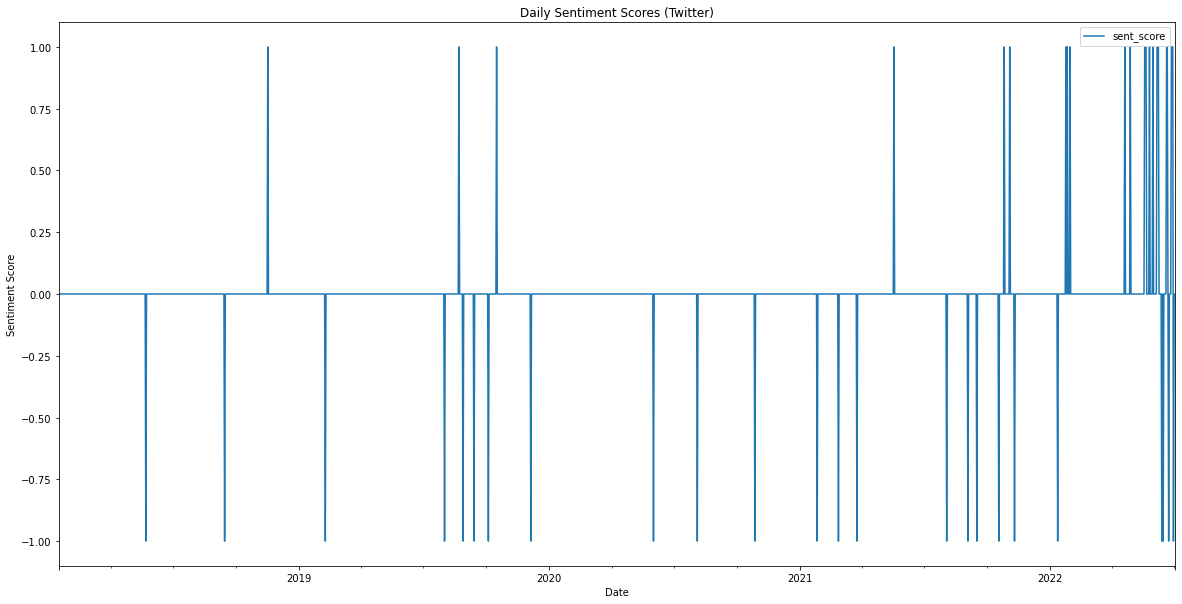

In [250]:
fig, ax = plt.subplots(figsize=(20,10))
daily_sent_scores.plot(ax=ax)
ax.set_title('Daily Sentiment Scores (Twitter)')
ax.set_xlabel('Date')
ax.set_ylabel('Sentiment Score')
plt.show();

---